In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [3]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")


In [5]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [7]:
merged_df = transactions.merge(customers, on='CustomerID', how='left')
merged_df = merged_df.merge(products, on='ProductID', how='left')


In [9]:

customer_features = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'TransactionDate': lambda x: (x.max() - x.min()).days,
    'ProductID': pd.Series.mode
}).rename(columns={'TotalValue': 'Total_Spend', 'TransactionID': 'Num_Transactions', 'TransactionDate': 'Recency', 'ProductID': 'Favorite_Product'})


In [13]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['Total_Spend', 'Num_Transactions', 'Recency']])
similarity_matrix = cosine_similarity(scaled_features)

In [15]:
customer_ids = customer_features.index[:20]
lookalikes = {}
for idx, cust_id in enumerate(customer_ids):
    similar_indices = np.argsort(similarity_matrix[idx])[::-1][1:4]
    lookalikes[cust_id] = [(customer_features.index[i], similarity_matrix[idx][i]) for i in similar_indices]

In [17]:
num_clusters = 5  # You can choose between 2 and 10 as per instructions
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)
customer_features['Cluster'] = kmeans_labels

C:\Users\shash\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [19]:
db_index = davies_bouldin_score(scaled_features, kmeans_labels)
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.9708759654199575


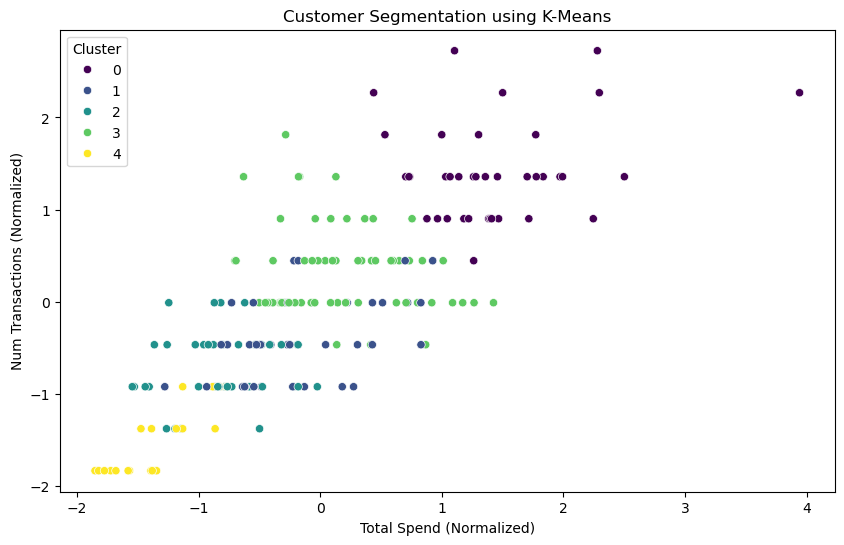

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1], hue=kmeans_labels, palette='viridis')
plt.title("Customer Segmentation using K-Means")
plt.xlabel("Total Spend (Normalized)")
plt.ylabel("Num Transactions (Normalized)")
plt.legend(title='Cluster')
plt.show()


In [29]:
customer_features.to_csv("Customer_Clusters.csv", index=True)